In [4]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

import numpy as np

from art.metrics import PDTP, SHAPr
from art.utils import load_nursery

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from art.estimators.classification.scikitlearn import ScikitlearnRandomForestClassifier, ScikitlearnDecisionTreeClassifier

(x_train, y_train), (x_test, y_test), _, _ = load_nursery(test_set=0.5)

model = RandomForestClassifier()
model.fit(x_train, y_train)
extra_model = RandomForestClassifier()

art_classifier = ScikitlearnRandomForestClassifier(model)
extra_classifier = ScikitlearnRandomForestClassifier(extra_model)

num_samples = 100

In [5]:
indexes = np.array(range(num_samples))
leakage = PDTP(art_classifier, extra_classifier, x_train, y_train, indexes=indexes)

print("Average PDTP leakage random forest: ", np.average(leakage))
print("Max PDTP leakage random forest: ", np.max(leakage))

Average PDTP leakage random forest:  1.2548805625189081
Max PDTP leakage random forest:  1.525054277029961


In [6]:
model2 = DecisionTreeClassifier()
model2.fit(x_train, y_train)
extra_model2 = DecisionTreeClassifier()

art_classifier2 = ScikitlearnDecisionTreeClassifier(model2)
extra_classifier2 = ScikitlearnDecisionTreeClassifier(extra_model2)

In [7]:
leakage2 = PDTP(art_classifier2, extra_classifier2, x_train, y_train, indexes=indexes, num_iter=1)
print("Average PDTP leakage decision tree: ", np.average(leakage2))
print("Max PDTP leakage decision tree: ", np.max(leakage2))

Average PDTP leakage decision tree:  1.0
Max PDTP leakage decision tree:  1.0


In [8]:
SHAPr_leakage = SHAPr(art_classifier, x_train, y_train, x_test, y_test)
print("Average SHAPr leakage random forest: ", np.average(SHAPr_leakage))
print("Max SHAPr leakage random forest: ", np.max(SHAPr_leakage))

SHAPr_leakage2 = SHAPr(art_classifier2, x_train, y_train, x_test, y_test)
print("Average SHAPr leakage decision tree: ", np.average(SHAPr_leakage2))
print("Max SHAPr leakage decision tree: ", np.max(SHAPr_leakage2))

Average SHAPr leakage random forest:  0.9763816
Max SHAPr leakage random forest:  2.6936393
Average PDTP leakage decision tree:  0.9822476
Max PDTP leakage decision tree:  1.0050056


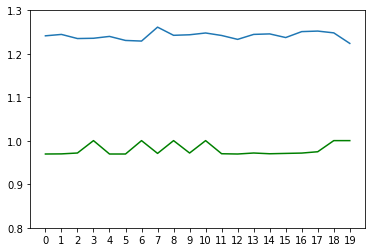

In [34]:
plt.plot(range(20), leakage[:20], label="pdtp")
plt.plot(range(20), SHAPr_leakage[:20], label="shap", color="green")
plt.xticks(range(20))
plt.ylim(0.8, 1.3)
plt.show()

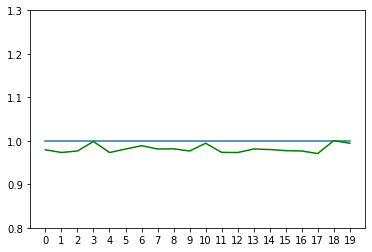

In [33]:
plt.plot(range(20), leakage2[:20], label="pdtp")
plt.plot(range(20), SHAPr_leakage2[:20], label="shap", color="green")
plt.xticks(range(20))
plt.ylim(0.8, 1.3)
plt.show()

In [13]:
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox

attack_train_ratio = 0.5
attack_train_size = int(len(x_train) * attack_train_ratio)
attack_test_size = int(len(x_test) * attack_train_ratio)

# random forest
bb_attack = MembershipInferenceBlackBox(art_classifier)

# train attack model
bb_attack.fit(x_train[attack_train_size:], y_train[attack_train_size:],
              x_test[attack_test_size:], y_test[attack_test_size:])

# get inferred values
inferred_train_bb = bb_attack.infer(x_train[:attack_train_size], y_train[:attack_train_size])
inferred_test_bb = bb_attack.infer(x_test[:attack_test_size], y_test[:attack_test_size])
# check accuracy
train_acc = np.sum(inferred_train_bb) / len(inferred_train_bb)
test_acc = 1 - (np.sum(inferred_test_bb) / len(inferred_test_bb))
acc = (train_acc * len(inferred_train_bb) + test_acc * len(inferred_test_bb)) / (len(inferred_train_bb) + len(inferred_test_bb))
print(train_acc)
print(test_acc)
print(acc)

0.6881753627662859
0.6452608829885766
0.6667181228774313


<ipython-input-26-870ba9113007>:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(range(20), SHAPr_leakage[:20], label="shap", linefmt="green")
<ipython-input-26-870ba9113007>:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(range(20), inferred_train_bb[:20], label="mem", linefmt="red")
/Users/abigailt/opt/anaconda3/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

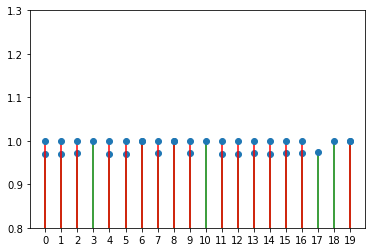

In [26]:
import matplotlib.pyplot as plt
# plt.stem(range(20), leakage[:20], label="pdtp")
plt.stem(range(20), SHAPr_leakage[:20], label="shap", linefmt="green")
plt.stem(range(20), inferred_train_bb[:20], label="mem", linefmt="red")
plt.xticks(range(20))
plt.ylim(0.8, 1.3)
plt.show()

In [15]:
# decision tree
bb_attack2 = MembershipInferenceBlackBox(art_classifier2)

# train attack model
bb_attack2.fit(x_train[attack_train_size:], y_train[attack_train_size:],
              x_test[attack_test_size:], y_test[attack_test_size:])

# get inferred values
inferred_train_bb2 = bb_attack2.infer(x_train[:attack_train_size], y_train[:attack_train_size])
inferred_test_bb2 = bb_attack2.infer(x_test[:attack_test_size], y_test[:attack_test_size])

# check accuracy
train_acc2 = np.sum(inferred_train_bb2) / len(inferred_train_bb2)
test_acc2 = 1 - (np.sum(inferred_test_bb2) / len(inferred_test_bb2))
acc2 = (train_acc2 * len(inferred_train_bb2) + test_acc2 * len(inferred_test_bb2)) / (len(inferred_train_bb2) + len(inferred_test_bb2))
print(train_acc2)
print(test_acc2)
print(acc2)

0.6384686631676443
0.3606051250385922
0.49953689410311825


In [17]:
inferred_train_bb2_prob = bb_attack2.infer(x_train[:attack_train_size], y_train[:attack_train_size], probabilities=True)

<ipython-input-27-784033f6dd5e>:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(range(20), SHAPr_leakage2[:20], label="shap", linefmt="green")
<ipython-input-27-784033f6dd5e>:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(range(20), inferred_train_bb2[:20], label="mem", linefmt="red")
/Users/abigailt/opt/anaconda3/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tu

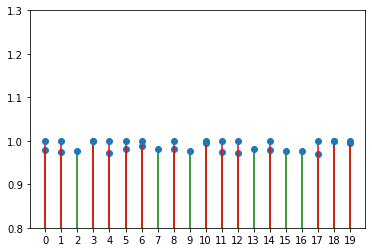

In [27]:
# plt.stem(range(20), leakage2[:20], label="pdtp")
plt.stem(range(20), SHAPr_leakage2[:20], label="shap", linefmt="green")
plt.stem(range(20), inferred_train_bb2[:20], label="mem", linefmt="red")
plt.xticks(range(20))
plt.ylim(0.8, 1.3)
plt.show()

In [35]:
import scipy

print(scipy.stats.pearsonr(SHAPr_leakage[:num_samples], leakage))

(-0.17031552811915138, 0.090237926270019)
